#575 Project 
##Michael Fergus & Andrew Maybach

##CPS Probation Analysis

In the following report  data from the Chicago Public Schools website (https://cps.edu/SchoolData/Pages/SchoolData.aspx) is used to model School Probation status based on School Performance and Demographic Metrics. The data being used is from the year 2013 and includes reports on Racial and Ethnic Identity, Bilingual, Special Education, Reduced or Free lunch, and perfomance metrics for 683 CPS Schools. Below are the steps taken for analysis and insights gained. 

In [175]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

Above we are importing the packages that we will need to run our analysis.

In [176]:
#setting seed
random.seed(123)

In the above cell we are setting our random seed for reproducability 

In [177]:
#Importing data - gathered from CPS website
lepsped = pd.read_excel('lep_iep_frl_report_2013.xls', sheetname='All Schools',skiprows = [0,1],
                        names = ["School_ID","Networks","School_Name","Total", "Bilingual_No",
                                 "Bilingual_Percent","SPED_No","SPED_Percent","Reduced_Lunch_No",
                                 "Reduced_Lunch_Percent"])


racial_ethnic= pd.read_excel('FY13_Racial_Ethnic_Survey.xls', sheetname='All Schools', skiprows= [0,1],
                            names=["Network","School_ID","School_Name","Total","White_No","White_Percent",
                                   "African_American_No","African_American_Percent","Asian_American_Pascific_Islander_No",
                                   "Asian_American_Pascific_Islander_Percent","Native_American_Alaskan_No",
                                   "Native_American_Alaskan_Percent","Hispanic_No","Hispanic_Percent","Multi_Racial_No",
                                   "Multi_Racial_Percent","Asian_No","Asian_Percent", "Hawaiian_Pacific_Islander_No",
                                   "Hawaiian_Pacific_Islander_Percent","Not_Available_No","Not_Available_Percent"] )

perf_elem = pd.read_excel("2013_PerformancePolicy_Results_03262014.xls", sheetname= "Elem 2013", skiprows = [0])

perf_high = pd.read_excel("2013_PerformancePolicy_Results_03262014.xls", sheetname= "High 2013", skiprows=[0])

Above we are importing our data; the first file contains data about each schools Special Education, Reduced Lunch, and Bilingual speakers. The second has Racial/Ethnic data for the schools. The last two files are performance data for elementary and highschool respectively. 

In [178]:
#rename scho0l id to match
perf_elem.rename(columns= {"School ID":"School_ID"},inplace = True)
perf_high.rename(columns= {"School ID":"School_ID"},inplace = True)                                
                               

The above cell renames the school ID columns in both of the performance data sets. This is important when joining the data later on. 

In [179]:
#Y value  encoding &  Previous Year Level encoding - encoding Probation Status and 2012-2013 level to numerics

#Elementary Y value
perf_elem["2013-2014 Probation Status"] = perf_elem["2013-2014 Probation Status"].map({"Not on Probation":0,"Probation":1, "Not Applicable":2})
#changing probation status data type to numeric
perf_elem["2013-2014 Probation Status"] = pd.to_numeric(perf_elem["2013-2014 Probation Status"])

#Highschool Y value
perf_high["2013-2014 Probation"] = perf_high["2013-2014 Probation"].map({"Not on Probation":0,"Probation":1, "Not Applicable":2})

#changing probation status data type to numeric
perf_high["2013-2014 Probation"] = pd.to_numeric(perf_high["2013-2014 Probation"])

#Previous year level encoding for elementary
perf_elem["2012-2013 Level"] = perf_elem["2012-2013 Level"].map({"Level 1":1,"Level 2":2, "Level 3":3, "Not Enough Data":4})

#changing Previous year level data type to numeric
perf_elem["2012-2013 Level"] = pd.to_numeric(perf_elem["2012-2013 Level"])

#Previous year level encoding for highschool
perf_high["2012-2013 Level"] = perf_high["2012-2013 Level"].map({"Level 1":1,"Level 2":2, "Level 3":3, "Not Enough Data":4})

#changing probation status data type to numeric
perf_high["2012-2013 Level"] = pd.to_numeric(perf_high["2012-2013 Level"])

The above cell maps Probation Status to either 0,1,or 2. 0 is not on probation, 1 is probation, and 2 is Not enough data. 
This cell also converts the Probation status column's data type to numeric.

In [180]:
#remvoing elementary and highschool "Not applicable" Probation statuses
perf_elem = perf_elem[perf_elem["2013-2014 Probation Status"] !=2]
perf_high = perf_high[perf_high["2013-2014 Probation"] !=2]

Here we have removed any schools that had "Not enough data" from our data. Both Highschool and Elementary data sets had some probation statuses of Not Enough Data and were removed from the analysis. This is also an area for improvement in our analysis. There were a lot of "Not enough data" assignments. Removing them decreases our sample and thus alters our results. 

In [181]:
#dropping school names and network from the elementary and highschool dataframes--these variables arent needed
perf_elem = perf_elem.drop(["Network","School Name"],axis= 1)
perf_high = perf_high.drop(["Network","School Name"],axis= 1)
lepsped = lepsped.drop(["Networks","School_Name"], axis = 1)
racial_ethnic = racial_ethnic.drop(["Network", "School_Name"], axis= 1)

The Network and School Name attributes were dropped from the data sets becuase they are thought to not hold any importance in determining Probation. 

In [183]:
#fixing last 2 rows- had extra data on import
lepsped = lepsped.iloc[:-2,:]
racial_ethnic = racial_ethnic.iloc[:-2,:]


The last few rows of the Racial/Ethnic data set and the Special Education/Free or Reduced lunch/Bilingual were not empty but did not hold information relevant to the analysis so they were removed above.

In [184]:
#changing School id datatype in LEPSPED import to numeric
lepsped["School_ID"] = pd.to_numeric(lepsped["School_ID"])

Above changed the data type of the Special Education/Free or Reduced lunch/Bilingual School ID attribute to numeric.

In [185]:
#combining racial and demographic data
dat = pd.merge(lepsped,racial_ethnic, how="outer", on="School_ID")

Racial/Ethnic data set and the Special Education/Free or Reduced lunch/Bilingual are merged on School ID above.

In [186]:
#combining Racial/Demographic with Elementary & Highschool Performance
elem_df = perf_elem.merge(dat,how="outer", on = "School_ID")
high_df = perf_high.merge(dat,how="outer", on = "School_ID")

Merging the Racial/Ethnic data set and the Special Education/Free or Reduced lunch/Bilingual merge to both the elementary and Highschool data.

In [187]:
# dropping NaN rows from both elem and higschool
# This removes the highschool rows from the elementary dataframe that were created with the merging and vice versa 
elem_df.dropna(subset=["2013-2014 Probation Status"],inplace=True)
high_df.dropna(subset=["2013-2014 Probation"], inplace= True)


NaN values introduced by combining elementary and highschool performance are removed in the above step by dropping ony where NaN were found in the Probation status attributes. When merging, all Highschools would have NaN for Elementary data and vice versa.

In [188]:
#filling na with average
elem_df = elem_df.fillna(elem_df.mean(),inplace= True)
high_df = high_df.fillna(high_df.mean(),inplace = True)

Any residual missing values were replaced with each columns average.

In [189]:
#setting x and y for both dataframes
elem_x = elem_df[list(elem_df.columns[0:2])+list(elem_df.columns[3:])]
elem_y = elem_df["2013-2014 Probation Status"]

high_x = high_df[list(high_df.columns[0:2])+list(high_df.columns[3:])]
high_y = high_df["2013-2014 Probation"]

The cell above designates Probation Status as our Target(Y) variable and everything else as our X variables. This splitting was done for both Elementary and Highshcool data.

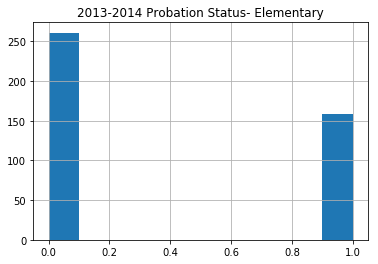

In [190]:
#Probation vs not Elemenatry
elem_y.hist()
plt.title("2013-2014 Probation Status- Elementary")

Histogram of Elementary Probation Status

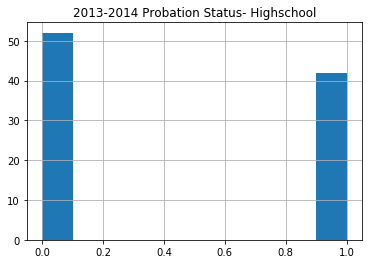

In [191]:
#Probation vs not High School
high_y.hist()
plt.title("2013-2014 Probation Status- Highschool")

Histogram of Highcshool Probation Status

As displayed in the histograms above, there is a pretty even ratio of probation to non- probation schools in both the elementary and Highschool spaces, highschool is roughly 5:4 and elementary is roughly 5:3.

In [192]:
#elementary descriptive statistics
print("Elementary Descriptive Statistics")
elem_df.describe()

Elementary Descriptive Statistics


,School_ID,Unit,2013-2014 Probation Status,2012-2013 Level,Total Percent of Possible Points,Total Points Received,Total Points Possible,2013 ISAT Composite Meets/ Exceeds Percent,2013,2012,...,Hispanic_No,Hispanic_Percent,Multi_Racial_No,Multi_Racial_Percent,Asian_No,Asian_Percent,Hawaiian_Pacific_Islander_No,Hawaiian_Pacific_Islander_Percent,Not_Available_No,Not_Available_Percent
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,...,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,608566.242857,4759.071429,0.378571,1.978571,59.951905,24.942857,41.671429,54.709524,50.563810,49.379475,...,285.811905,37.463333,6.602381,1.109048,21.630952,3.033095,0.985714,0.142143,4.328571,0.810952
std,17708.136854,1739.379890,0.485609,0.815727,21.129448,8.770289,1.882375,17.226133,17.748845,18.133644,...,361.441922,37.736523,10.772168,1.657676,68.113022,8.229093,3.740992,0.413507,10.969328,2.078581
min,400040.000000,2015.000000,0.000000,1.000000,7.100000,3.000000,24.000000,16.300000,9.900000,9.400000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,609909.750000,3267.500000,0.000000,1.000000,45.200000,19.000000,42.000000,42.275000,37.350000,35.500000,...,6.000000,1.600000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,610054.500000,4635.000000,0.000000,2.000000,59.500000,25.000000,42.000000,53.600000,48.600000,47.750000,...,118.500000,23.050000,2.000000,0.400000,1.000000,0.100000,0.000000,0.000000,1.000000,0.100000
75%,610195.250000,6112.500000,1.000000,3.000000,76.800000,32.000000,42.000000,66.125000,61.925000,60.250000,...,465.000000,79.950000,7.250000,1.300000,10.250000,1.925000,1.000000,0.200000,3.250000,0.600000
max,610559.000000,9597.000000,1.000000,4.000000,100.000000,42.000000,42.000000,99.800000,100.000000,100.000000,...,1847.000000,99.200000,76.000000,10.000000,810.000000,85.800000,57.000000,5.900000,96.000000,20.700000


Descriptive Statistics for Elementary School

In [193]:
#highschool descriptive statistics
print("Highschool Descriptive Statistics")
high_df.describe()

Highschool Descriptive Statistics


,School_ID,Unit,2013-2014 Probation,2012-2013 Level,Total Percent of Possible Points,Total Points Received,Total Points Possible,2013 PSAE Composite Meets/ Exceeds Percent,2013,2012,...,Hispanic_No,Hispanic_Percent,Multi_Racial_No,Multi_Racial_Percent,Asian_No,Asian_Percent,Hawaiian_Pacific_Islander_No,Hawaiian_Pacific_Islander_Percent,Not_Available_No,Not_Available_Percent
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,598791.585106,3221.244681,0.446809,2.212766,51.429787,20.386521,39.542553,27.038043,17.019565,17.116667,...,408.585106,35.862766,11.404255,1.040426,41.063830,2.656383,0.893617,0.077660,4.563830,0.394681
std,47356.826549,2842.559364,0.499828,0.774213,20.446257,8.366674,6.435227,24.693732,3.342500,3.107440,...,556.676571,33.518234,19.525731,1.263492,91.537266,4.992350,1.562106,0.124567,10.904826,0.751682
min,400018.000000,1010.000000,0.000000,1.000000,0.000000,0.000000,9.000000,0.400000,12.900000,12.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,609710.250000,1342.500000,0.000000,2.000000,39.100000,15.333000,42.000000,8.475000,14.700000,15.000000,...,11.000000,1.900000,2.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,609737.500000,1605.000000,0.000000,2.000000,51.200000,21.000000,42.000000,20.700000,16.350000,16.550000,...,175.000000,27.950000,3.000000,0.500000,1.500000,0.200000,0.000000,0.000000,1.000000,0.100000
75%,610338.500000,6900.000000,1.000000,3.000000,61.825000,25.166500,42.000000,35.450000,18.100000,18.075000,...,625.750000,67.175000,9.000000,1.300000,20.250000,2.925000,1.000000,0.100000,3.000000,0.300000
max,610558.000000,9598.000000,1.000000,4.000000,100.000000,42.000000,42.000000,98.800000,29.400000,29.600000,...,2533.000000,97.100000,110.000000,5.800000,418.000000,24.100000,9.000000,0.700000,77.000000,4.500000


Descriptive Statistics for Highschool

In [194]:
#Model Definition
elem_mod = RandomForestClassifier(n_estimators=100).fit(elem_x,elem_y)
high_mod = RandomForestClassifier(n_estimators=100).fit(high_x,high_y)

elem_log_mod = LogisticRegression().fit(elem_x, elem_y)
high_log_mod = LogisticRegression().fit(high_x, high_y)


Above both Random Forest and Logistic regression models are fit on both the highschool and elementary school data.

In [195]:
print("Elementary Logistic Regression Cross-Validated Score")
cross_val_score(elem_log_mod,elem_x,elem_y,cv=10).mean()


Elementary Logistic Regression Cross-Validated Score


0.86658698646787136

Cross validated Logistic regression score for the Elementary school data.

In [196]:
print("High School Logistic Regression Cross-Validated Score")
cross_val_score(high_log_mod,high_x,high_y,cv=10).mean()

High School Logistic Regression Cross-Validated Score


0.83030303030303032

Cross validated Logistic regression score for the Highschool data.

In [197]:
elem_score = cross_val_score(elem_mod,elem_x,elem_y, cv=10).mean()
print("Elementary Random Forest Cross-Validated Score")
elem_score

Elementary Random Forest Cross-Validated Score


0.93337519920049705

Cross validated Random Forest score for the Elementary school data.

In [198]:
high_score = cross_val_score(high_mod,high_x,high_y, cv= 10).mean()
print("Highschool Random Forest Cross-Validated Score")
high_score

Highschool Random Forest Cross-Validated Score


0.9242424242424242

Cross validated Random Forest score for the Highschool data.

In [199]:
elem_feature_importances = pd.DataFrame(elem_mod.feature_importances_,index = elem_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print("Elementary Feature Importance")
elem_feature_importances.head(10)

Elementary Feature Importance


,importance
Total Percent of Possible Points,0.138303
2012-2013 Level,0.108537
Total Points Received,0.103486
2013.3,0.076912
2013 ISAT Composite Meets/ Exceeds Percent,0.047349
Current Status.2,0.039620
2013.1,0.037361
2013,0.029227
2013.2,0.029152
Current Status.1,0.027118


Feature Importance for Elementary School Random Forest

In [200]:
high_feature_importances = pd.DataFrame(high_mod.feature_importances_,index = high_x.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
print("Highschool Feature Importance")
high_feature_importances.head(10)

Highschool Feature Importance


,importance
2012.6,0.090491
2013 PSAE Composite Meets/ Exceeds Percent,0.065999
2012,0.064335
2011.6,0.054934
2012.5,0.054619
Current Status.5,0.051569
2013.6,0.043235
2013,0.038633
Current Status.6,0.037393
Current Status,0.035071


Feature Importance for Highschool Random Forest

Both elementary and highschool Classifiers were accurate in predicting Probation status, with the elementary scoring slightly higher than the highschool model when cross validated (See Results Above)
When looking at feature importances of the elementary model, fearutes such as"Total Points Recieved" and "Total Percent of Possible Points" were some of the most important. This seems logical and one woluld expect that overall points would be one of the most important metrics. However, while examining the important features of the highschool model, the feature 2012.6, which corresponds to the "PSAE Math" for the year 2012. Scoring better in math (or any other subject) intuitively makes sense as an important factor for a school's probation status. However, Math score showing up as an important feature in determining if a school is going to be on probation or not provides valuable insight. Future investigation into what improves Math scores in could very well lead to improvements in CPS Highschool probation status rates.